In [1]:
import sys
import requests
sys.path.insert(0,'/home/jcdn500/Documents/abTEM')
sys.path.insert(0,'/home/jcdn500/Documents/abTEM/abtem')
import numpy as np
from abtem import *
import matplotlib.pyplot as plt

from abtem.waves import PlaneWave
from ase.io import read, write
from abtem.potentials import Potential

/home/jcdn500/.local/lib/python3.8/site-packages/ase/calculators/neighborlist.py:5: UserWarning: Moved to ase.neighborlist
  warnings.warn('Moved to ase.neighborlist')


In [2]:
import sys
import requests
sys.path.insert(0,'/home/jcdn500/Documents/abTEM')
sys.path.insert(0,'/home/jcdn500/Documents/abTEM/abtem')
import numpy as np
from abtem import *
import matplotlib.pyplot as plt

from abtem.waves import PlaneWave
from ase.io import read, write
from abtem.potentials import Potential


from ase.dft.kpoints import get_special_points, get_bandpath
from ase.spacegroup import Spacegroup

from ase.visualize import view

In [3]:
# atoms = read('./Ni_FCC.cif')
atoms = read('./Fe_cubic.cif')

In [4]:
import sympy as sym

## Set magnetic moments
# pi=sym.pi
# magmoms=[[2,pi,0], [2,0,0], [2,0,0], [2,pi,0]]
# atoms.set_initial_magnetic_moments(magmoms)


## Set magnetic moments
pi=sym.pi
magmoms=[[2,0,0]]
atoms.set_initial_magnetic_moments(magmoms)

In [5]:
# Visualize the atoms with magmoms
print(atoms.positions)
view(atoms)

[[0. 0. 0.]]


In [6]:
# Js=np.zeros([2,2,3])
# for i in range(2):
#     for j in range(2):
#         for k in range(3):
#             if i==j and k==0:
#                 Js[i,j,k]=1.39 
#             if i!=j and k==0:
#                 Js[i,j,k]=1.34 
#             if i!=j and k==2:
#                 Js[i,j,k]=-19.04
# print(Js)

Js=np.zeros([1,1,1])
for i in range(1):
    for j in range(1):
        for k in range(1):
            if i==j and k==0:
                Js[i,j,k]=2 

print(Js)

[[[2.]]]


In [7]:
lat = atoms.cell.get_bravais_lattice()
print(list(lat.get_special_points()))

path =  atoms.cell.bandpath('GMGX', npoints=1000)

['G', 'M', 'R', 'X']


In [8]:
Input_mag=MagnonInput(atoms,
                      interaction=Js,
                      anisotropies=0,
                      qpts=path.kpts,
                      Temperature=300.0,
                      inelastic_layer=[0])

In [9]:
H, orientationEach= Input_mag.Hamiltonian_film()

In [10]:
orientationEach

array([[2., 0., 0.]])

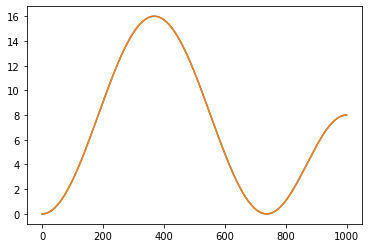

In [11]:
eVals_full,eVecs_fullL,eVecs_fullR = Input_mag.diagonalize_function(H)
plt.plot(eVals_full.real)

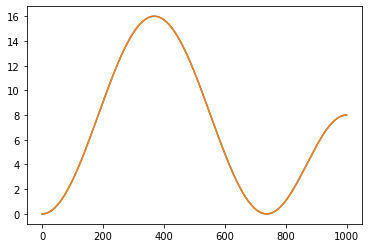

In [12]:
plt.plot(eVals_full.real)

In [13]:
Lists_of_Neigbours=Input_mag.get_neigb(0.01)
#print(Lists_of_Neigbours)

In [14]:
Input_mag.M

1

In [15]:
H_main=np.zeros([Input_mag.M,Input_mag.M,len(path.kpts)],dtype=complex)
H_main1=np.zeros([Input_mag.M,Input_mag.M,len(path.kpts)],dtype=complex)
H_off1=np.zeros([Input_mag.M,Input_mag.M,len(path.kpts)],dtype=complex)
H_off2=np.zeros([Input_mag.M,Input_mag.M,len(path.kpts)],dtype=complex)
H_final=np.zeros([2*Input_mag.M,2*Input_mag.M,len(path.kpts)],dtype=complex)


In [16]:
#path.kpts

In [17]:
H_main=np.zeros([Input_mag.M,Input_mag.M,len(path.kpts)],dtype=complex)
H_main1=np.zeros([Input_mag.M,Input_mag.M,len(path.kpts)],dtype=complex)
H_off1=np.zeros([Input_mag.M,Input_mag.M,len(path.kpts)],dtype=complex)
H_off2=np.zeros([Input_mag.M,Input_mag.M,len(path.kpts)],dtype=complex)
H_final=np.zeros([2*Input_mag.M,2*Input_mag.M,len(path.kpts)],dtype=complex)

for num,j in enumerate(Lists_of_Neigbours):
    for i in j:
        
        r=np.where((orientationEach==Input_mag._atoms.get_initial_magnetic_moments()[i[0]]).all(axis=1))[0][0]
        s=np.where((orientationEach==Input_mag._atoms.get_initial_magnetic_moments()[i[1]]).all(axis=1))[0][0]
        
        Sr=orientationEach[r,0]
        Ss=orientationEach[s,0]
        
        FzzM=Fzz(Input_mag,i[0],i[1])
        G1M=G1(Input_mag,i[0],i[1])
        G2M=G2(Input_mag,i[0],i[1])
        
        Gamma=(np.exp(-1.0j*np.dot(get_distance_vector(Input_mag,i),np.transpose(2*np.pi*(path.kpts/Input_mag._atoms.cell.diagonal())))))
        #print(G1M)
        
        H_main[r,r,:]+=Input_mag._interaction[r,s,num]*Ss*FzzM
        H_main[s,s,:]+=Input_mag._interaction[r,s,num]*Sr*FzzM
        H_main[r,s,:]-=Input_mag._interaction[r,s,num]*(np.sqrt(Sr*Ss)/2)*(np.conj(Gamma)*G1M + Gamma*np.conj(G1M))

        H_main1[r,r,:]+=Input_mag._interaction[r,s,num]*Ss*FzzM
        H_main1[s,s,:]+=Input_mag._interaction[r,s,num]*Sr*FzzM
        H_main1[r,s,:]-=Input_mag._interaction[r,s,num]*(np.sqrt(Sr*Ss)/2)*(np.conj(Gamma)*np.conj(G1M) + Gamma*G1M)

        H_off1[r,s,:]-=Input_mag._interaction[r,s,num]*(np.sqrt(Sr*Ss)/2)*(np.conj(Gamma)*np.conj(G2M) + Gamma*np.conj(G2M))

        H_off2[r,s,:]-=Input_mag._interaction[r,s,num]*(np.sqrt(Sr*Ss)/2)*(np.conj(Gamma)*G2M + Gamma*G2M)
    
        
    for i in range(len(path.kpts)):
        H_final[:,:,i]=(1/4)*np.block([[H_main[:,:,i],-H_off1[:,:,i]],
                                 [H_off2[:,:,i],-(H_main1[:,:,i])]])

NameError: name 'Fzz' is not defined

In [ ]:
gamma = (1/3)*(np.cos(2*np.pi*(path.kpts[:,0])) +np.cos(2*np.pi*(path.kpts[:,1])) +np.cos(2*np.pi*(path.kpts[:,2])))

In [ ]:
plt.plot(6*1*2*(1-gamma))

In [ ]:
H_final[:,:,0]

In [ ]:
eVals_full,eVecs_fullL,eVecs_fullR = Input_mag.diagonalize_function(H_final)
plt.plot(eVals_full.real*2,'--')

#plt.plot(6*1*2*(1-gamma),'k')
plt.ylim([-100,100])
plt.show()

In [21]:
def get_distance_vector(Input_mag,bondpair):
    Pos_Atom_1 = Input_mag._atoms.positions[bondpair[0]]
    Pos_Atom_2 = Input_mag._atoms.positions[bondpair[1]]+np.dot(bondpair[2],Input_mag._atoms.cell)
    distanceVector = Pos_Atom_2 - Pos_Atom_1
    return distanceVector

def scos(x): return sym.N(sym.cos(x))

def ssin(x): return sym.N(sym.sin(x))

def get_theta(mag):
    return sym.acos(mag[2]/np.linalg.norm(mag))

def get_phi(mag):
    if mag[0]>0:
        return sym.atan(mag[1]/mag[0])
    if mag[0]<0 and mag[1]>=0:
        return sym.atan(mag[1]/mag[0]) + sym.pi
    if mag[0]<0 and mag[1]<0:
        return sym.atan(mag[1]/mag[0]) - sym.pi
    if mag[0]==0 and mag[1]>0:
        return sym.pi/2
    if mag[0]==0 and mag[1]<0:
        return -sym.pi/2
    if mag[0]==0 and mag[1]==0:
        return 0


def Fzz(Atoms,r,s):
        
    theta_r = Atoms._atoms.get_initial_magnetic_moments()[r,1]
    phi_r = Atoms._atoms.get_initial_magnetic_moments()[r,2]
    
    theta_s = Atoms._atoms.get_initial_magnetic_moments()[s,1]
    phi_s = Atoms._atoms.get_initial_magnetic_moments()[s,2]
    
    SinProd=ssin(theta_r)*ssin(theta_s)
    CosProd=scos(theta_r)*scos(theta_s)
    
    CosDiff=scos(phi_r-phi_s)
    
    return float(SinProd*CosDiff + CosProd)


def G1(Atoms,r,s):
        
    theta_r = Atoms._atoms.get_initial_magnetic_moments()[r,1]
    phi_r = Atoms._atoms.get_initial_magnetic_moments()[r,2]
    
    theta_s = Atoms._atoms.get_initial_magnetic_moments()[s,1]
    phi_s = Atoms._atoms.get_initial_magnetic_moments()[s,2]
    
    SinProd=ssin(theta_r)*ssin(theta_s)
    CosProd=scos(theta_r)*scos(theta_s)
    
    SinDiff=ssin(phi_r-phi_s)
    CosDiff=scos(phi_r-phi_s)
    
    CosPlus=scos(theta_r) + scos(theta_s)
    
    return float(((CosProd + 1)*CosDiff) + SinProd - (1.0j*SinDiff*CosPlus))


def G2(Atoms,r,s):
       
    theta_r = Atoms._atoms.get_initial_magnetic_moments()[r,1]
    phi_r = Atoms._atoms.get_initial_magnetic_moments()[r,2]
    
    theta_s = Atoms._atoms.get_initial_magnetic_moments()[s,1]
    phi_s = Atoms._atoms.get_initial_magnetic_moments()[s,2]

    SinProd=ssin(theta_r)*ssin(theta_s)
    CosProd=scos(theta_r)*scos(theta_s)
    
    SinDiff=ssin(phi_r-phi_s)
    CosDiff=scos(phi_r-phi_s)
    
    CosMinus=scos(theta_r) - scos(theta_s)
    
    return float(((CosProd - 1)*CosDiff) + SinProd - (1.0j*SinDiff*CosMinus))


## Spin-spin scattering funciton ##

In [ ]:
X=np.zeros(np.shape(eVecs_fullL),dtype=complex)

for i in range(np.shape(eVecs_fullL)[-1]):
    X[:,:,i] = np.linalg.inv(eVecs_fullL[:,:,i])


In [ ]:
def v_matrix_plus(Atoms,r,alpha):

    direction=['x','y','z']    
    
    if alpha not in direction:
        raise ValueError("the directions must be either the strings 'x' 'y' or 'z'")
    
    alpha=direction.index(alpha)
    
    theta_r = Atoms._atoms.get_initial_magnetic_moments()[r,1]
    phi_r = Atoms._atoms.get_initial_magnetic_moments()[r,2]
    
    U=np.array([[scos(theta_r)*scos(phi_r),scos(theta_r)*ssin(phi_r),-ssin(theta_r)],
                [-ssin(phi_r),scos(phi_r),0],
                [ssin(theta_r)*scos(phi_r),ssin(theta_r)*ssin(phi_r),scos(theta_r)]])
    
    return float(U[0,alpha] + complex(0,U[1,alpha]))

def v_matrix_minus(Atoms,r,alpha):
 
    direction=['x','y','z']

    if alpha not in direction:
        raise ValueError("the directions must be either the strings 'x' 'y' or 'z'")

    
    alpha=direction.index(alpha)
    
    theta_r = Atoms._atoms.get_initial_magnetic_moments()[r,1]
    phi_r = Atoms._atoms.get_initial_magnetic_moments()[r,2]
    
    U=np.array([[scos(theta_r)*scos(phi_r),scos(theta_r)*ssin(phi_r),-ssin(theta_r)],
                [-ssin(phi_r),scos(phi_r),0],
                [ssin(theta_r)*scos(phi_r),ssin(theta_r)*ssin(phi_r),scos(theta_r)]])
    
    return float(U[0,alpha] - complex(0,U[1,alpha]))

In [ ]:
v_matrix_minus(Input_mag,0,'x')

In [ ]:
M=Input_mag.M
omega=np.linspace(-100,100,1000)
print(M)

In [ ]:
print(v_matrix_minus(Input_mag,r,'x'))
print(X[n,r,0])
print(v_matrix_plus(Input_mag,r,'x'))
print(X[n,r+M,0])
print()
print(eVecs_fullL[:,:,0])
print()
print(X[:,:,0])

In [ ]:
SpinSpin=np.zeros([1000,1000])
#print(type(SpinSpin))

for Enum,E in enumerate(omega):
    for n in range(2*M):
        Smatrix=0
        for r in range(M):
            for s in range(M):
                
                
                W=v_matrix_minus(Input_mag,r,'x')*X[n,r,:] + v_matrix_plus(Input_mag,r,'x')*X[n,r+M,:]
                Wconj=np.conj(v_matrix_minus(Input_mag,s,'x')*X[n,s,:] + v_matrix_plus(Input_mag,s,'x')*X[n,s+M,:])

                Smatrix+=(W*Wconj)
#                 print(W[0])
#                 print(Wconj[0])
#                 print()
#                 print((W*Wconj)[0])
#                 print()
                #print(type(Smatrix))
                #print(type(SpinSpin[Enum,:]))

        SpinSpin[-Enum,:] = SpinSpin[-Enum,:] + (bose_einstein_distribution(abs(E), 0,300)+1)*(Smatrix*lorentzian_distribution(E, eVals_full[:,n], thickness))


In [ ]:
SpinSpin

In [ ]:
# Plot the heatmap
# Plot the heatmap with a custom color for NaN values
cmap = plt.cm.hot
cmap.set_bad('gray')  # Set the color for NaN values

plt.imshow(SpinSpin, cmap=cmap,
           vmin=0.01, vmax=1,
           aspect=np.shape(SpinSpin)[1]/np.shape(SpinSpin)[0])
plt.colorbar()

# Show the plot
plt.show()

In [ ]:
np.max(SpinSpin)


In [ ]:
omega=np.linspace(0,100,1000)

In [ ]:
import numpy as np

def lorentzian_distribution(energy, energy_ref, thickness):
    """
    Compute the value of the Lorentzian distribution at a given energy.

    Parameters:
    energy (float): The energy at which to evaluate the Lorentzian distribution.
    energy_ref (float): The reference energy (center) of the distribution.
    thickness (float): The thickness (scale) parameter of the distribution.

    Returns:
    float: The value of the Lorentzian distribution at the given energy.
    """
    return 1.0 / (np.pi * thickness * (1.0 + ((energy - energy_ref) / thickness) ** 2))

# Example usage
energy = 1.5
energy_ref = 20.0
thickness = 0.5
result = lorentzian_distribution(energy, energy_ref, thickness)
print("Value of Lorentzian distribution:", result)


In [ ]:
def bose_einstein_distribution(energy, chemical_potential, temperature):
    k_ev = 8.617333262145e-5  # Boltzmann constant in ev/K

    # Evaluate the Bose-Einstein distribution
    difference = energy - chemical_potential
#     if np.abs(difference) < 1e-12:  # Handle the case of small energy differences
#         distribution = (k_ev * temperature) / energy
#    else:
    distribution = 1 / (np.exp(difference / (k_ev * temperature)) - 1)

    return distribution

In [ ]:
plt.plot(omega,lorentzian_distribution(omega, 0, thickness))

In [ ]:
np.max(lorentzian_distribution(omega, 100, thickness))

In [18]:
Lists_of_Neigbours=Input_mag.get_neigb(0.01)

In [19]:
print(Lists_of_Neigbours)

[[(0, 0, array([0, 0, 1])), (0, 0, array([0, 1, 0])), (0, 0, array([1, 0, 0])), (0, 0, array([ 0,  0, -1])), (0, 0, array([ 0, -1,  0])), (0, 0, array([-1,  0,  0]))]]


In [29]:
for num,j in enumerate(Lists_of_Neigbours):
    for i in j:
        Gamma=(np.exp(-1.0j*np.dot(get_distance_vector(Input_mag,i),np.transpose(2*np.pi*(path.kpts/Input_mag._atoms.cell.diagonal())))))
print(Gamma)

[ 1.00000000e+00-0.00000000e+00j  9.99963561e-01+8.53683286e-03j
  9.99854245e-01+1.70730436e-02j  9.99672061e-01+2.56080100e-02j
  9.99417022e-01+3.41411102e-02j  9.99089147e-01+4.26717222e-02j
  9.98688460e-01+5.11992243e-02j  9.98214989e-01+5.97229951e-02j
  9.97668769e-01+6.82424134e-02j  9.97049841e-01+7.67568582e-02j
  9.96358248e-01+8.52657091e-02j  9.95594042e-01+9.37683459e-02j
  9.94757279e-01+1.02264149e-01j  9.93848019e-01+1.10752499e-01j
  9.92866328e-01+1.19232778e-01j  9.91812278e-01+1.27704367e-01j
  9.90685946e-01+1.36166649e-01j  9.89487414e-01+1.44619008e-01j
  9.88216769e-01+1.53060826e-01j  9.86874105e-01+1.61491490e-01j
  9.85459518e-01+1.69910385e-01j  9.83973112e-01+1.78316897e-01j
  9.82414995e-01+1.86710413e-01j  9.80785280e-01+1.95090322e-01j
  9.79084088e-01+2.03456013e-01j  9.77311540e-01+2.11806876e-01j
  9.75467768e-01+2.20142304e-01j  9.73552904e-01+2.28461687e-01j
  9.71567089e-01+2.36764420e-01j  9.69510468e-01+2.45049899e-01j
  9.67383189e-01+2.533175

/home/jcdn500/.local/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1369: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


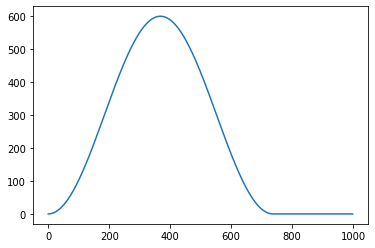

In [30]:
plt.plot(6*25*2*(1-Gamma))